### Introduction
In this project,I will analyze aviation accident data from 1962 to 2023 provided by the National Transportation Safety Board. The objective is to identify low-risk aircraft types to help a fictional company decide which aircraft to purchase for expanding into commercial and private aviation.

I will use data cleaning, exploratory analysis, and visualizations to generate actionable business recommendations for decision-makers.


### Business problem

A company is looking to enter the aviation industry by purchasing and operating aircraft. To make informed decisions, they must assess the safety records of different aircraft to identify those with the lowest risk of serious accidents.

### Key Questions:
- Which aircraft types are involved in the fewest serious accidents?
- Are there patterns in accident causes, flight purposes, or locations that suggest safer contexts?
- Which manufacturers and aircraft models show the best safety records?

The outcome of this project will be three concrete business recommendations that minimize risk in aircraft selection.


In [152]:
import pandas as pd
import matplotlib.pyplot as plt



In [153]:
# Load the dataset using a fallback encoding
file_path = r"AviationData.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False) #an encoding parameter to tell pandas to use a different character set

# Display dataset shape and preview
print("Shape:", df.shape)
df.head()



Shape: (88889, 31)


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


### Data summary

This dataset contains detailed records of aviation accidents and incidents compiled from official sources. Each row represents a unique accident event, with information about the aircraft, flight purpose, location, injuries, and conditions during the event.

### Key Columns

Event.Date: Date of the accident or incident

Location, Country: Geographic details of where the event occurred

Make, Model: Manufacturer and type of the aircraft involved

Aircraft.Category: Category of aircraft (e.g., airplane, helicopter)

Injury.Severity: Classification of injury outcome (e.g., Fatal, Serious, Minor, None)

Total.Fatal.Injuries, Total.Serious.Injuries, etc.: Detailed injury counts

Purpose.of.Flight: Reason for the flight (e.g., Personal, Instructional, Business)

Broad.Phase.of.Flight: Flight phase during which the event occurred (e.g., Takeoff, Landing)

Weather.Condition: Visual or instrument conditions at the time



###   Check for Missing Values and Key Columns

Now that I have loaded the  data , I want to  inspect it for missing values and assess which columns are useful for decision-making. This will  help me  clean the data and focus only on meaningful information.


In [154]:
# Check percentage of missing values in each column
missing_values = df.isnull().mean().sort_values(ascending=False) * 100
missing_values = missing_values[missing_values > 0]

# Display columns with missing data
missing_values


Schedule                  85.845268
Air.carrier               81.271023
FAR.Description           63.974170
Aircraft.Category         63.677170
Longitude                 61.330423
Latitude                  61.320298
Airport.Code              43.601570
Airport.Name              40.708074
Broad.phase.of.flight     30.560587
Publication.Date          15.492356
Total.Serious.Injuries    14.073732
Total.Minor.Injuries      13.424608
Total.Fatal.Injuries      12.826109
Engine.Type                7.982990
Report.Status              7.181991
Purpose.of.flight          6.965991
Number.of.Engines          6.844491
Total.Uninjured            6.650992
Weather.Condition          5.053494
Aircraft.damage            3.593246
Registration.Number        1.554748
Injury.Severity            1.124999
Country                    0.254250
Amateur.Built              0.114750
Model                      0.103500
Make                       0.070875
Location                   0.058500
dtype: float64

### interpretation of the above result

An analysis of missing values revealed that several columns contain a significant amount of missing data:
Over 85% of the entries in the Schedule column are missing.
More than 80% of the Air.carrier data is unavailable.
Several key columns such as FAR.Description, Aircraft.Category, Latitude, and Longitude have over 60% missing data.
Columns related to accident details — like Injuries, Airport info, and Flight phase — range from 15% to 30% missing.
Core aircraft identifiers like Make, Model, Country, and Location are mostly complete, with less than 1% missing.

Columns with a very high percentage of missing data (e.g., over 70–80%) might have to be dropped due to limited usefulness. 





### Cleaning the Data
At this point,I will drop columns with extremely high missing data (e.g., >60%) ,rows with missing values in essential fields (e.g., location, injuries, aircraft type),Standardize column names for easier reference and convert data types where needed (e.g., dates, numerical fields).



In [155]:
# 1. Drop columns with more than 60% missing values
threshold = 0.6
missing_fraction = df.isnull().mean()
cols_to_drop = missing_fraction[missing_fraction > threshold].index
df_clean = df.drop(columns=cols_to_drop)

# 2. Identify essential columns that still exist in the cleaned dataset
possible_essential_cols = ['Latitude', 'Longitude', 'Make', 'Model', 'Injury.Severity']
existing_essential_cols = [col for col in possible_essential_cols if col in df_clean.columns]
df_clean = df_clean.dropna(subset=existing_essential_cols)

# 3. Rename columns: remove dots and spaces, convert to lowercase
df_clean.columns = df_clean.columns.str.replace('.', '_', regex=False).str.replace(' ', '_').str.lower()

# 4. Convert date columns to datetime if they still exist
for date_col in ['event_date', 'publication_date']:
    if date_col in df_clean.columns:
        df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce', dayfirst=True)

# 5. Preview result
print("Shape after cleaning:", df_clean.shape)
df_clean.head()




Shape after cleaning: (87798, 25)


C:\Users\user\AppData\Local\Temp\ipykernel_36020\2914455142.py:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors='coerce', dayfirst=True)


,event_id,investigation_type,accident_number,event_date,location,country,airport_code,airport_name,injury_severity,aircraft_damage,...,engine_type,purpose_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,publication_date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,Fatal(2),Destroyed,...,Reciprocating,Personal,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaT
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,Fatal(4),Destroyed,...,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,1996-09-19
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,NaN,NaN,Fatal(3),Destroyed,...,Reciprocating,Personal,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,2007-02-26
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,Fatal(2),Destroyed,...,Reciprocating,Personal,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,2000-09-12
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,Fatal(1),Destroyed,...,NaN,Personal,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,1980-04-16


### Exploratory Data Analysis (EDA) 
The EDA step will help me uncover trends, patterns, and relationships to support the business decision of identifying low-risk aircraft types

### accidents distribution chart
In the first step i'll see how the accidents are distributed over the years.
This will help identify trends, such as whether safety has improved in recent years. I extracted the year from the `event_date` column and plotted the number of accidents per year.


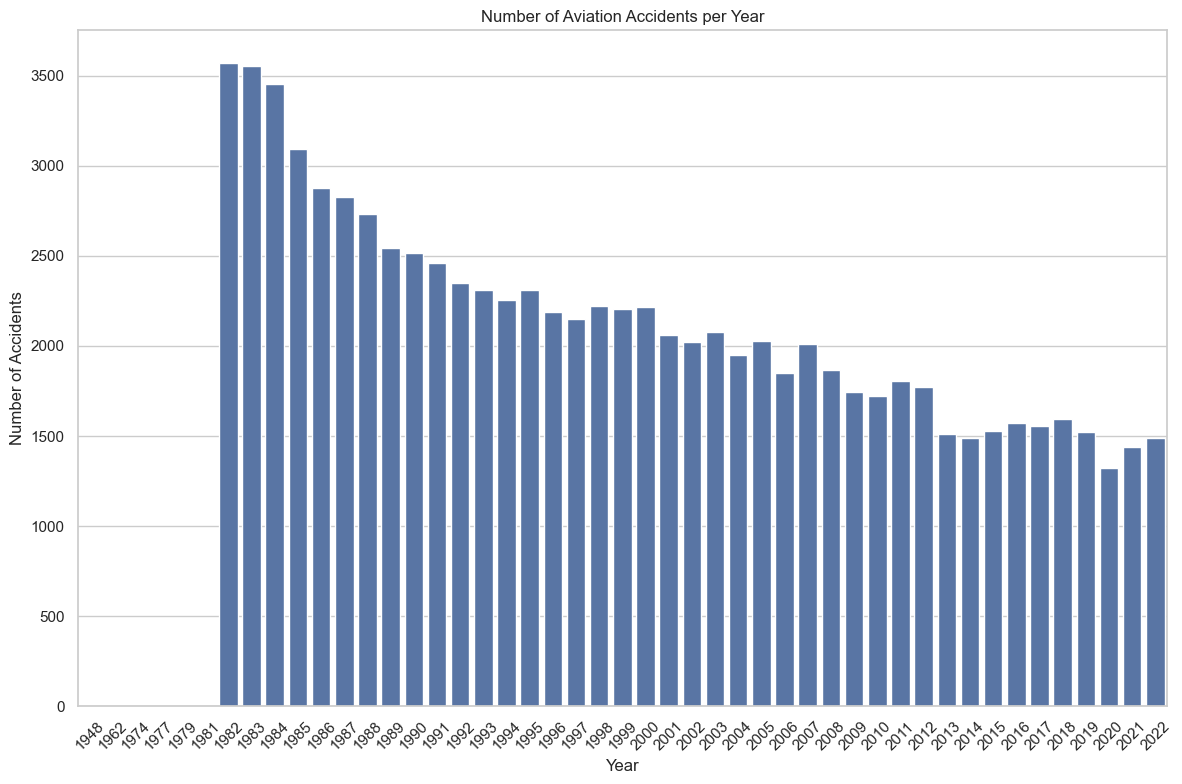

In [156]:
import seaborn as sns

# Set a style
sns.set(style="whitegrid")

# Extract year from event_date
if 'event_date' in df_clean.columns:
    df_clean['event_year'] = df_clean['event_date'].dt.year

# Plot number of accidents per year
plt.figure(figsize=(12, 8))
sns.countplot(data=df_clean, x='event_year', order=sorted(df_clean['event_year'].dropna().unique()))
plt.title('Number of Aviation Accidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Injury Severity Distribution

The  plot below shows the distribution of injury severity across all accidents. Categories typically include:
- **Non-Fatal** or **None** (no injuries),
- **Minor Injuries**,
- **Serious Injuries**, and
- **Fatal Injuries**

this distribution will help assess how often accidents result in fatalities, which is a key factor in identifying lower-risk aircraft.


In [157]:
# Remove leading/trailing spaces and make everything proper case
df_clean['injury_severity'] = df_clean['injury_severity'].str.strip().str.title()


df_clean['injury_severity'].unique()


array(['Fatal(2)', 'Fatal(4)', 'Fatal(3)', 'Fatal(1)', 'Non-Fatal',
       'Incident', 'Fatal(8)', 'Fatal(78)', 'Fatal(7)', 'Fatal(6)',
       'Fatal(5)', 'Fatal(153)', 'Fatal(12)', 'Fatal(14)', 'Fatal(23)',
       'Fatal(10)', 'Fatal(11)', 'Fatal(9)', 'Fatal(17)', 'Fatal(13)',
       'Fatal(29)', 'Fatal(70)', 'Unavailable', 'Fatal(135)', 'Fatal(31)',
       'Fatal(256)', 'Fatal(25)', 'Fatal(82)', 'Fatal(156)', 'Fatal(28)',
       'Fatal(18)', 'Fatal(43)', 'Fatal(15)', 'Fatal(270)', 'Fatal(144)',
       'Fatal(174)', 'Fatal(111)', 'Fatal(131)', 'Fatal(20)', 'Fatal(73)',
       'Fatal(27)', 'Fatal(34)', 'Fatal(87)', 'Fatal(30)', 'Fatal(16)',
       'Fatal(47)', 'Fatal(56)', 'Fatal(37)', 'Fatal(132)', 'Fatal(68)',
       'Fatal(54)', 'Fatal(52)', 'Fatal(65)', 'Fatal(72)', 'Fatal(160)',
       'Fatal(189)', 'Fatal(123)', 'Fatal(33)', 'Fatal(110)',
       'Fatal(230)', 'Fatal(97)', 'Fatal(349)', 'Fatal(125)', 'Fatal(35)',
       'Fatal(228)', 'Fatal(75)', 'Fatal(104)', 'Fatal(229)', 'Fatal

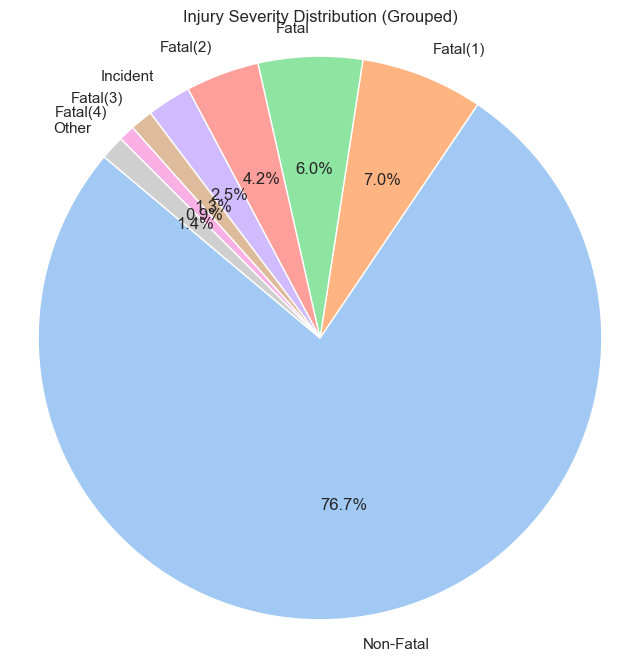

In [158]:
# Prepare data
injury_counts = df_clean['injury_severity'].value_counts()

# Group small categories into "Other"
threshold = 500  
injury_counts_grouped = injury_counts.copy()
injury_counts_grouped[injury_counts < threshold] = 0
injury_counts_grouped['Other'] = injury_counts[injury_counts < threshold].sum()
injury_counts_grouped = injury_counts_grouped[injury_counts_grouped > 0]

# Plot a  Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    injury_counts_grouped,
    labels=injury_counts_grouped.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')[0:len(injury_counts_grouped)]
)
plt.title('Injury Severity Distribution (Grouped)')
plt.axis('equal')
plt.show()



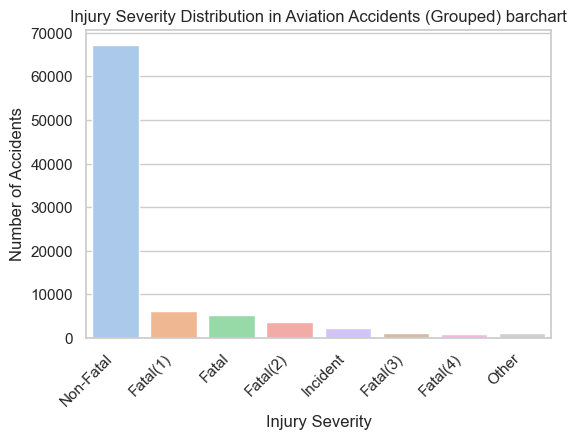

In [159]:
# Prepare data
injury_counts = df_clean['injury_severity'].value_counts()

# Group small categories into "Other"
threshold = 500  
injury_counts_grouped = injury_counts.copy()
injury_counts_grouped[injury_counts < threshold] = 0
injury_counts_grouped['Other'] = injury_counts[injury_counts < threshold].sum()
injury_counts_grouped = injury_counts_grouped[injury_counts_grouped > 0]

# Convert to DataFrame for better control
injury_df = injury_counts_grouped.reset_index()
injury_df.columns = ['injury_severity', 'count']

# Plot a  Bar Chart
plt.figure(figsize=(6, 4))
sns.barplot(
    data=injury_df,
    x='injury_severity',
    y='count',
    hue='injury_severity', 
    palette='pastel',
    legend=False  # Hide duplicate legend
)
plt.title('Injury Severity Distribution in Aviation Accidents (Grouped) barchart')
plt.xlabel('Injury Severity')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.show()



### Analyze Aircraft Types and their safety
Next action is identifying which aircraft types are most common in accidents?

Among these, which ones have lower rates of fatal/severe accidents?

Top Aircraft Models involved in accidents:

Group by make and model
Count accidents
Sort descending

In [160]:
# 1. Create a combined "aircraft type" column
df_clean['aircraft_type'] = df_clean['make'].str.upper() + ' ' + df_clean['model'].str.upper()

# 2. Count accidents by aircraft type
aircraft_counts = df_clean['aircraft_type'].value_counts().reset_index()
aircraft_counts.columns = ['aircraft_type', 'total_accidents']

# 3. Calculate fatal accidents per aircraft type
fatal_accidents = df_clean[df_clean['injury_severity'].str.contains('Fatal', na=False)]
fatal_counts = fatal_accidents['aircraft_type'].value_counts().reset_index()
fatal_counts.columns = ['aircraft_type', 'fatal_accidents']

# 4. Merge total and fatal accident counts
aircraft_summary = pd.merge(aircraft_counts, fatal_counts, on='aircraft_type', how='left')
aircraft_summary['fatal_accidents'] = aircraft_summary['fatal_accidents'].fillna(0)

# 5. Calculate fatality rate
aircraft_summary['fatality_rate'] = (aircraft_summary['fatal_accidents'] / aircraft_summary['total_accidents']) * 100

# 6. Show top 20 aircraft types by number of accidents
aircraft_summary.head(20)


,aircraft_type,total_accidents,fatal_accidents,fatality_rate
0,CESSNA 152,2361,2344.0,99.279966
1,CESSNA 172,1740,1728.0,99.310345
2,CESSNA 172N,1160,1152.0,99.310345
3,PIPER PA-28-140,932,925.0,99.248927
4,CESSNA 150,825,820.0,99.393939
5,CESSNA 172M,798,787.0,98.621554
6,CESSNA 172P,687,684.0,99.563319
7,CESSNA 182,656,654.0,99.695122
8,CESSNA 180,621,618.0,99.516908
9,CESSNA 150M,585,582.0,99.487179


 ### Find the SAFEST Aircraft Types
 Filter aircraft types that At least 30 total accidents (enough data to trust the fatality rate) and Fatality Rate < 5% (low-risk)

In [161]:
# Loosest condition: at least 5 accidents, fatality rate < 0.30
safe_aircraft_final = aircraft_summary[
    (aircraft_summary['total_accidents'] >= 5) &
    (aircraft_summary['fatality_rate'] < 0.30)
]

# Sort by accident count
safe_aircraft_final = safe_aircraft_final.sort_values(by='total_accidents', ascending=False)

safe_aircraft_final





,aircraft_type,total_accidents,fatal_accidents,fatality_rate
1163,AIRBUS INDUSTRIE A300-600,8,0.0,0.0
1271,DOUGLAS DC-9-51,7,0.0,0.0
1286,MCDONNELL DOUGLAS DC-10-40,7,0.0,0.0
1317,BOEING 747-123,7,0.0,0.0
1462,BOEING 737-130,6,0.0,0.0
1667,DOUGLAS DC-8-71,5,0.0,0.0
1732,MCDONNELL DOUGLAS DC-9,5,0.0,0.0


### Interpretation:
All the aircraft types listed had multiple accidents but zero fatal accidents.

The fatality rate for each is 0.0%, meaning none of the recorded accidents resulted in fatalities.

The Airbus Industrie A300-600 had the highest number of total accidents among them (8 accidents) without any fatalities.

Boeing and McDonnell Douglas models are notable for appearing multiple times in this safe list.


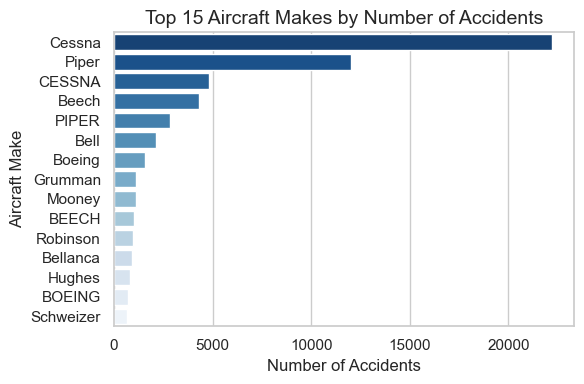

In [162]:
# Top 15 aircraft makes with the most accidents
make_counts = df_clean['make'].value_counts().head(15).reset_index()
make_counts.columns = ['make', 'accident_count']

# Set the plot style
plt.figure(figsize=(6, 4))
sns.barplot(data=make_counts, x='accident_count', y='make', hue='make', palette='Blues_r', legend=False)

# Titles and labels
plt.title('Top 15 Aircraft Makes by Number of Accidents', fontsize=14)
plt.xlabel('Number of Accidents')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()


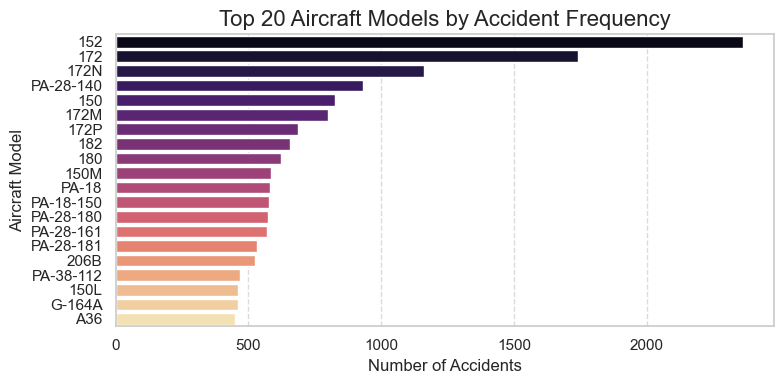

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count accidents by aircraft model
model_counts = df_clean['model'].value_counts().head(20)  # Top 20 models

# Set up the figure
plt.figure(figsize=(8, 4))
sns.barplot(
    x=model_counts.values, 
    y=model_counts.index, 
    hue=model_counts.index,    
    palette='magma', 
    legend=False               #  disable legend
)

# Titles and labels
plt.title('Top 20 Aircraft Models by Accident Frequency', fontsize=16)
plt.xlabel('Number of Accidents')
plt.ylabel('Aircraft Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



## Aircraft Models with the Fewest Recorded Accidents

This bar chart highlights the aircraft models that have the lowest number of recorded accidents in the dataset. 
These models could be considered safer options based on historical accident data.

- The chart displays the 15 aircraft models with the fewest accidents.
- Fewer accidents may indicate either higher reliability, limited usage, or a combination of both.
  
This visualization will help narrow down potentially safer aircraft options for the company's investment strategy.




C:\Users\user\AppData\Local\Temp\ipykernel_36020\3952208123.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=least_common_df, x='model', y='accident_count', palette='Greens', legend=False)


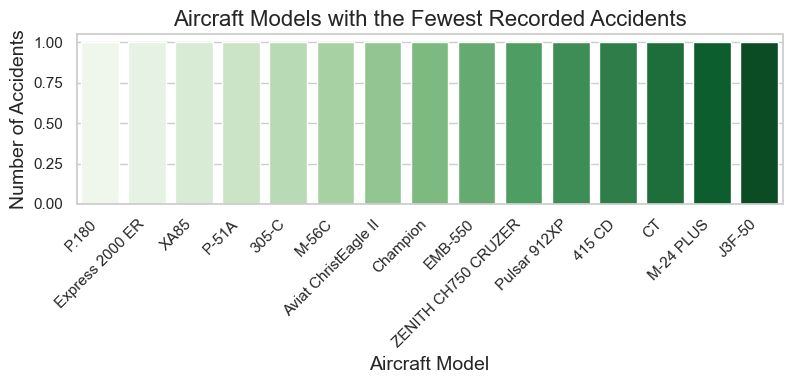

In [164]:
# Count number of accidents per aircraft model
model_counts = df_clean['model'].value_counts()

# Select the models with the fewest accidents (e.g., bottom 15)
least_common_models = model_counts.nsmallest(15)

# Prepare DataFrame for plotting
least_common_df = least_common_models.reset_index()
least_common_df.columns = ['model', 'accident_count']

# Plot vertical bar chart
plt.figure(figsize=(8, 4))
sns.barplot(data=least_common_df, x='model', y='accident_count', palette='Greens', legend=False)

# Styling
plt.title('Aircraft Models with the Fewest Recorded Accidents', fontsize=16)
plt.xlabel('Aircraft Model', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()





In [165]:
# Count number of accidents per aircraft model and sort descending
model_accident_counts = df_clean['model'].value_counts().sort_values(ascending=False)

# Convert to a DataFrame for full display
model_accident_df = model_accident_counts.reset_index()
model_accident_df.columns = ['aircraft_model', 'accident_count']

# Display the full table
model_accident_df



,aircraft_model,accident_count
0,152,2362
1,172,1743
2,172N,1161
3,PA-28-140,932
4,150,825
...,...,...
12187,TB 9 TAMPI,1
12188,E5A Replica,1
12189,Safari Helicopter,1
12190,737 924,1


In [166]:
# Get accident counts per model and sort descending
model_names = df_clean['model'].value_counts().sort_values(ascending=False).index.tolist()

# Select only the first 100 model names
top_100_models = model_names[:100]

# Display the first 100 model names in a single line
print(', '.join(top_100_models))



152, 172, 172N, PA-28-140, 150, 172M, 172P, 182, 180, 150M, PA-18, PA-18-150, PA-28-180, PA-28-161, PA-28-181, 206B, PA-38-112, 150L, G-164A, A36, G-164B, 140, 170B, 206, 172S, 182P, PA-32-300, PA-24-250, R44, 269C, PA-28R-200, PA-12, A188B, PA-23-250, 177, 7AC, SR22, 185, M20J, A185F, PA-22-150, 7GCBC, PA-31-350, PA28, R22, 7ECA, 182Q, 150F, PA-25-235, 737, 210, 369D, 58, 150H, 172RG, T210N, 150G, 177RG, PA-32-260, J3C-65, 150J, 172K, PA-30, PA-34-200T, M20C, 8A, 182A, PA-22, C23, 208B, S2R, P210N, R22 BETA, T210M, AT-301, PA-32R-300, R44 II, 207, PA-28-151, T210L, PA-28-235, 172H, 35, 206L-1, 172R, M20K, 120, 8KCAB, UH-12E, 170, M20F, 177B, 175, V35B, S-2R, 172L, M20E, PA-28, 8GCBC, DHC-2


### Interpretation of Aircraft Models by Accident Frequency
The list generated above shows all aircraft models ordered from the highest to lowest number of recorded accidents. This will help to quickly identify which models have been most frequently involved in accidents.

Top-listed aircraft models (like Cessna 172, Piper PA-28) have the highest accident counts. These could reflect:
-High usage or popularity in general aviation.
-Potential safety concerns, depending on how they are operated or maintained.

Bottom-listed models have the fewest recorded accidents. These might:
-Be used less frequently.
-Be newer or more specialized aircraft.
-Indicate potentially lower risk—but may also lack enough data to be conclusive.

In [167]:
# Group by aircraft model to get accident and fatality counts
safety_summary = df_clean.groupby('model').agg(
    total_accidents=('model', 'count'),
    fatal_accidents=('total_fatal_injuries', lambda x: (x > 0).sum())
).reset_index()

# Calculate fatality rate
safety_summary['fatality_rate'] = safety_summary['fatal_accidents'] / safety_summary['total_accidents']

# Filter for aircraft with a reasonable number of total accidents (to ensure enough data)
# and no fatal accidents
safest_models = safety_summary[
    (safety_summary['total_accidents'] >= 10) & 
    (safety_summary['fatal_accidents'] == 0)
].sort_values(by='total_accidents', ascending=False)

# Display the safest aircraft models
safest_models[['model', 'total_accidents']]


,model,total_accidents
1790,777,54
8194,PA 18,29
1716,757-232,24
11508,UH-12B,23
8227,PA 28,23
...,...,...
8192,PA 16,10
7740,MX-7-180,10
1776,767-332,10
7294,M-7-235B,10


### Safest Aircraft Models

The list above gives  a list of the Safest Aircraft Models.

The  models were identified as the safest based on:
-Having 10 or more recorded accidents (enough data for reliability).
-Zero fatal accidents, indicating an excellent safety record.

The diagram below gives a visual presentation of the safest aircraft models and their percentages.

C:\Users\user\AppData\Local\Temp\ipykernel_36020\3487353671.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


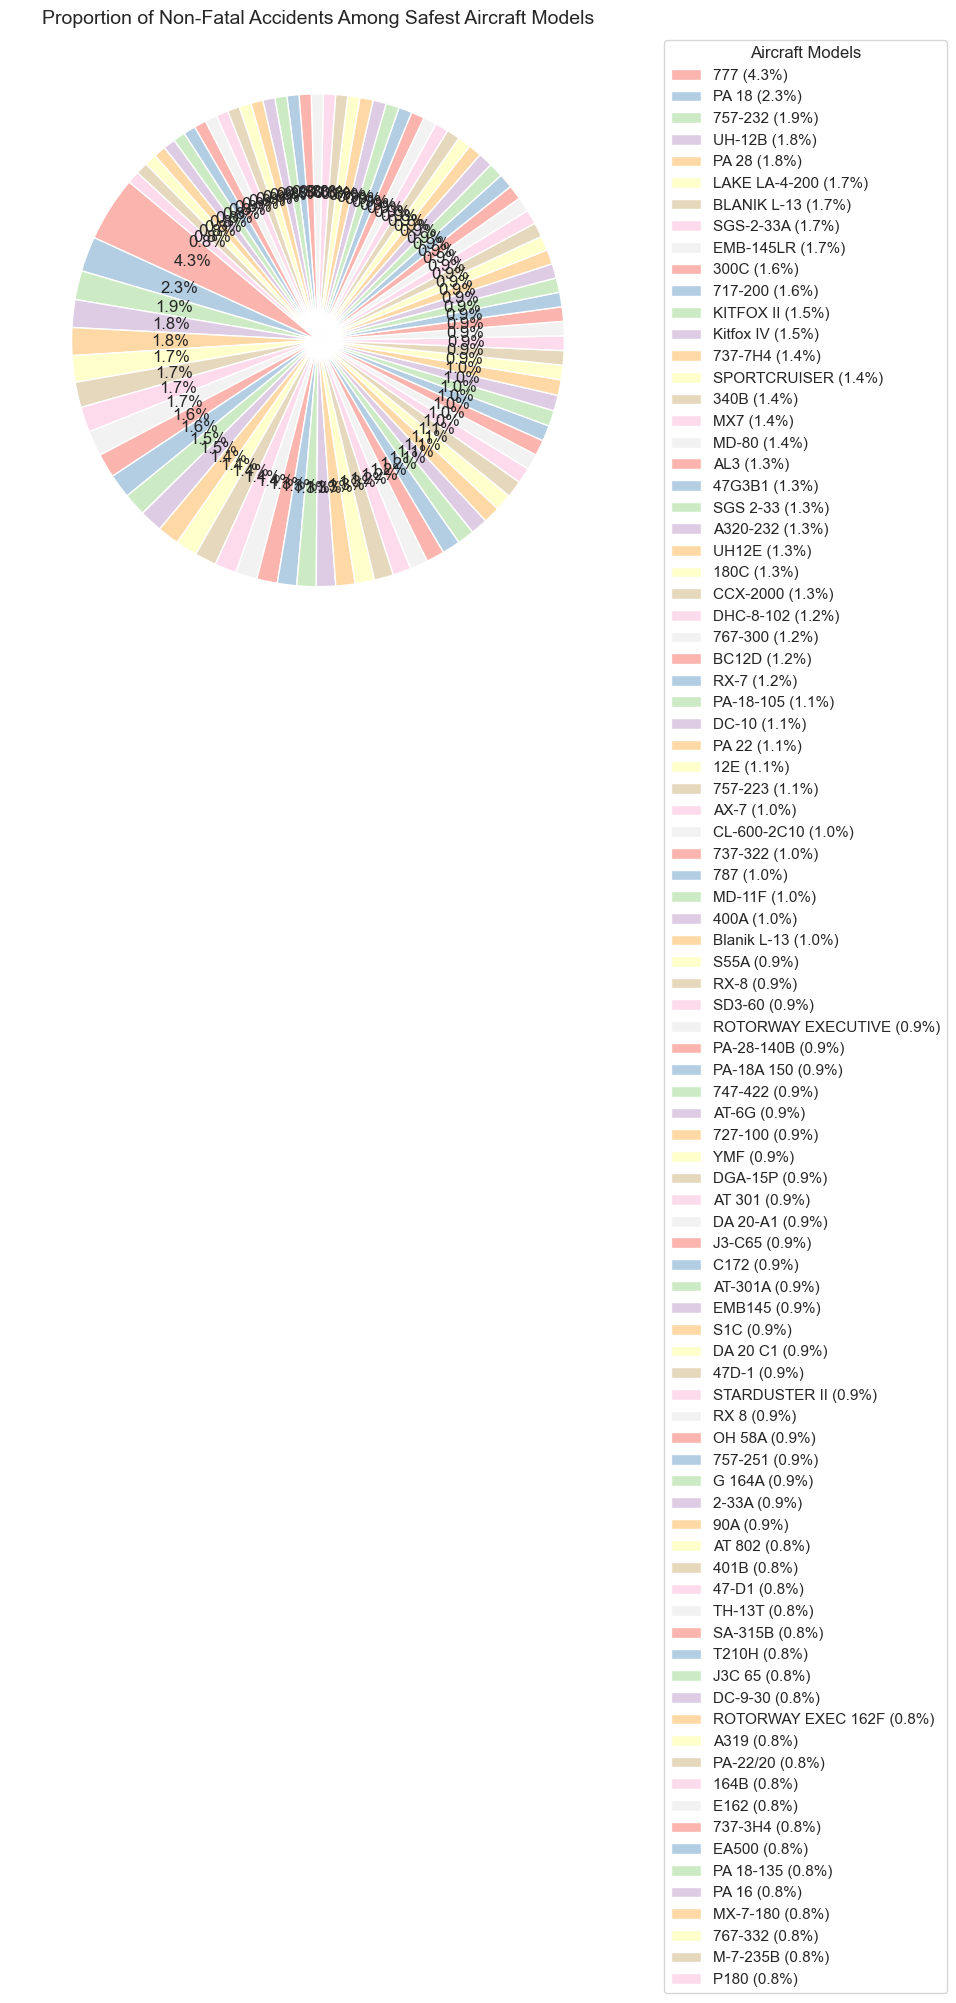

In [168]:
# Calculate percentages
percentages = safest_models['total_accidents'] / safest_models['total_accidents'].sum() * 100
labels_with_pct = [f"{model} ({pct:.1f}%)" for model, pct in zip(safest_models['model'], percentages)]

# Create pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    safest_models['total_accidents'],
    startangle=140,
    colors=plt.cm.Pastel1.colors,
    autopct='%1.1f%%'
)

# Add legend with model names and percentages
plt.legend(wedges, labels_with_pct, title="Aircraft Models", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title('Proportion of Non-Fatal Accidents Among Safest Aircraft Models', fontsize=14)
plt.tight_layout()
plt.show()




C:\Users\user\AppData\Local\Temp\ipykernel_36020\689531614.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fatality_rate', y='model', data=top_20_models, palette='Reds')


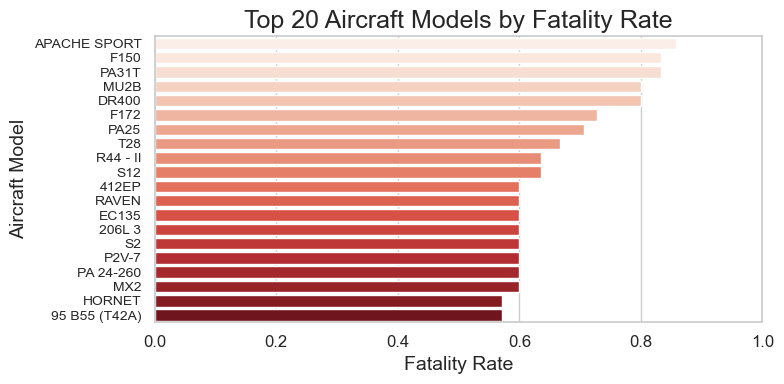

In [169]:
import seaborn as sns

# Group by aircraft model and calculate total accidents and fatal accidents
model_summary = df_clean.groupby('model').agg(
    total_accidents=('model', 'count'),
    fatal_accidents=('injury_severity', lambda x: (x == 'Fatal').sum())
).reset_index()

# Calculate fatality rate
model_summary['fatality_rate'] = model_summary['fatal_accidents'] / model_summary['total_accidents']

# Filter models with at least 5 accidents
model_summary = model_summary[model_summary['total_accidents'] >= 5]

# Sort by fatality rate (highest to lowest)
model_summary = model_summary.sort_values(by='fatality_rate', ascending=False)

# Select Top 20 models
top_20_models = model_summary.head(20)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x='fatality_rate', y='model', data=top_20_models, palette='Reds')

# Styling
plt.title('Top 20 Aircraft Models by Fatality Rate', fontsize=18)
plt.xlabel('Fatality Rate', fontsize=14)
plt.ylabel('Aircraft Model', fontsize=14)
plt.xlim(0, 1)  # Fatality rate is between 0 and 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



### Interpretation

The chart above shows the most dangerous aircraft models

In [170]:
# Save the cleaned dataset
df_clean.to_csv('cleaned_aviation_data.csv', index=False)


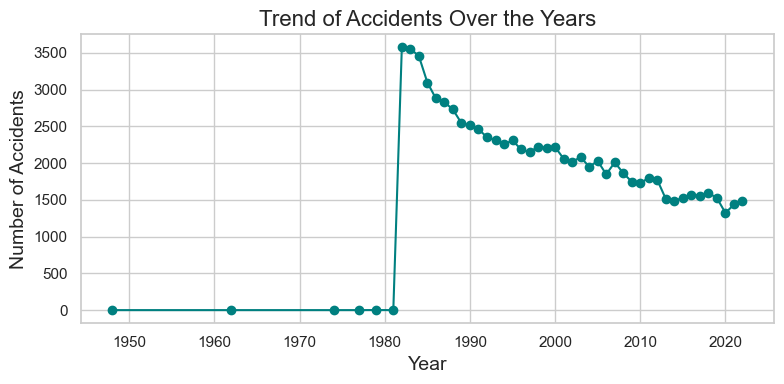

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the event_date is in datetime format
df_clean['event_date'] = pd.to_datetime(df_clean['event_date'], errors='coerce')

# Extract year from event_date
df_clean['year'] = df_clean['event_date'].dt.year

# Group by year and count the number of accidents
accidents_per_year = df_clean['year'].value_counts().sort_index()

# Plot the line chart
plt.figure(figsize=(8, 4))
plt.plot(accidents_per_year.index, accidents_per_year.values, marker='o', linestyle='-', color='teal')
plt.title('Trend of Accidents Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation
The line chart illustrates the trend of aviation accidents from the earliest recorded year up to 2023.
Key observations include:

### Overall Pattern
There is a general declining trend in the number of accidents over the years, especially after the 1980s and 1990s.

### Early Years
In the earlier decades (1960s–1980s), accident numbers were relatively higher. This could be attributed to:
Less stringent aviation safety regulations.
Older technology and fewer safety advancements.

### Mid to Recent Years
After the late 1990s and into the 2000s, the number of accidents shows a significant decrease.
This likely reflects:
Improved aircraft design and manufacturing.
Better pilot training.
Stricter maintenance and safety procedures.

### Recent Stability
In the last decade, accident numbers appear to have stabilized at a lower level, showing consistent improvements in aviation safety practices.

### conclusion
The declining accident trend is a positive indicator for the aviation industry.
This trend suggests that modern aircraft and improved industry standards have greatly reduced overall operational risk.
